In [27]:
import os
import sys
cwd = os.getcwd()
module_path = "/".join(cwd.split('/')[0:-1])
if module_path not in sys.path:
    sys.path.append(module_path)
import torch
import random
import matplotlib.pyplot as plt
import torch.backends.cudnn as cudnn
import numpy as np

In [28]:
from torchvision import datasets
from torchvision import transforms

# Import dataloaders
import Data.cifar10 as cifar10
import Data.svhn as svhn

In [29]:
# Import network architectures
from Net.resnet import resnet50, resnet110
from Net.wide_resnet import wide_resnet_cifar
from Net.densenet import densenet121

In [30]:
# Import metrics to compute
from Metrics.ood_test_utils import get_roc_auc

In [31]:
# Import plot related libraries
import seaborn as sb
import matplotlib.pyplot as plt

In [32]:
# Dataset params
dataset_num_classes = {
    'cifar10': 10,
    'svhn': 10
}

dataset_loader = {
    'cifar10': cifar10,
    'svhn': svhn,
}

In [33]:
# Mapping model name to model function
models = {
    'resnet50': resnet50,
    'resnet110': resnet110,
    'wide_resnet': wide_resnet_cifar,
    'densenet121': densenet121,
}

In [34]:
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
torch.cuda.device_count()

1

In [35]:
# Checking if GPU is available
cuda = False
if (torch.cuda.is_available()):
    cuda = True

# Setting additional parameters
torch.manual_seed(1)
device = torch.device("cuda" if cuda else "cpu")

In [36]:
class args:
    data_aug = True
    gpu = device == "cuda"
    train_batch_size = 128
    test_batch_size = 128

In [37]:
dataset = 'cifar10'
num_classes = dataset_num_classes[dataset]
test_loader = dataset_loader[dataset].get_test_loader(
    batch_size=args.test_batch_size,
    pin_memory=args.gpu
)

Files already downloaded and verified


In [39]:
normalize = transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                                 std=[0.2023, 0.1994, 0.2010],)
transform = transforms.Compose([transforms.ToTensor(), normalize,])
test_transform = transform

ood_test_data = datasets.CIFAR10('./data', train=False, transform=test_transform, download=False)
base_path = '/research3/arindam.ghosh/focal_calibration/data/CIFAR-10-C/'
corruption = 'gaussian_noise'
ood_test_data.data = np.load(base_path + corruption + '.npy')[-10000:,:,:,:] 
ood_test_data.targets = torch.LongTensor(np.load(base_path + 'labels.npy'))[-10000:]

ood_test_loader = torch.utils.data.DataLoader(
        ood_test_data,
        batch_size=args.test_batch_size,
        shuffle=False,
        num_workers=4,
        pin_memory=args.gpu)

## Resnet110

In [46]:
# AutoAdaptiveFocalLoss v2, gamma=1, lambda=1
model_name = 'resnet110'
saved_model_name = '../Experiments/adaFocal_15bins/cifar10_resnet110_adaFocal_v2_gamma1_lambda1_gammaMax20/resnet110_auto_adaptive_focal_loss_v2_1.0_350.model'
model = models[model_name]

net = model(num_classes=num_classes, temp=1.0)
net.cuda()
# net = torch.nn.DataParallel(net, device_ids=range(torch.cuda.device_count()))
net = torch.nn.DataParallel(net, device_ids=[0])
cudnn.benchmark = True
net.load_state_dict(torch.load('./' + str(saved_model_name)))

(fpr_entropy, tpr_entropy, thresholds_entropy), \
(fpr_confidence, tpr_confidence, thresholds_confidence), \
auc_entropy, auc_confidence = get_roc_auc(net, test_loader, ood_test_loader, device)

print('AUC entropy based:', auc_entropy*100)
fpr_entropy_resnet110_adafocal, tpr_entropy_resnet110_adafocal = fpr_entropy, tpr_entropy

AUC entropy based: 84.96854600000002


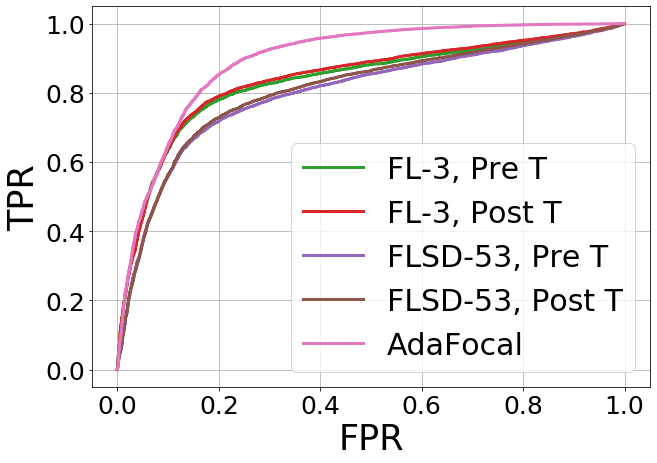

In [66]:
clrs = ['#1f77b4','#ff7f0e', '#2ca02c','#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22','#17becf']
linewidth = 3
fig, ax = plt.subplots(figsize=(10,7))

# Resnet110
# ax.plot(fpr_entropy_resnet110_ce_pre, tpr_entropy_resnet110_ce_pre, color=clrs[0], linewidth=linewidth, label='CE, Pre T')
# ax.plot(fpr_entropy_resnet110_ce_post, tpr_entropy_resnet110_ce_post, color=clrs[1], linewidth=linewidth, label='CE, Post T')
# ax.plot(fpr_entropy_resnet110_fl3_pre, tpr_entropy_resnet110_fl3_pre, color=clrs[2], linewidth=linewidth, label='FL-3, Pre T')
# ax.plot(fpr_entropy_resnet110_fl3_post, tpr_entropy_resnet110_fl3_post, color=clrs[3], linewidth=linewidth, label='FL-3, Post T')
# ax.plot(fpr_entropy_resnet110_flsd53_pre, tpr_entropy_resnet110_flsd53_pre, color=clrs[4], linewidth=linewidth, label='FLSD-53, Pre T')
# ax.plot(fpr_entropy_resnet110_flsd53_post, tpr_entropy_resnet110_flsd53_post, color=clrs[5], linewidth=linewidth, label='FLSD-53, Post T')
# ax.plot(fpr_entropy_resnet110_adafocal, tpr_entropy_resnet110_adafocal, color=clrs[6], linewidth=linewidth, label='AdaFocal')

# Wideresnet
# ax.plot(fpr_entropy_wideresnet_ce_pre, tpr_entropy_wideresnet_ce_pre, color=clrs[0], linewidth=linewidth, label='CE, Pre T')
# ax.plot(fpr_entropy_wideresnet_ce_post, tpr_entropy_wideresnet_ce_post, color=clrs[1], linewidth=linewidth, label='CE, Post T')
ax.plot(fpr_entropy_wideresnet_fl3_pre, tpr_entropy_wideresnet_fl3_pre, color=clrs[2], linewidth=linewidth, label='FL-3, Pre T')
ax.plot(fpr_entropy_wideresnet_fl3_post, tpr_entropy_wideresnet_fl3_post, color=clrs[3], linewidth=linewidth, label='FL-3, Post T')
ax.plot(fpr_entropy_wideresnet_flsd53_pre, tpr_entropy_wideresnet_flsd53_pre, color=clrs[4], linewidth=linewidth, label='FLSD-53, Pre T')
ax.plot(fpr_entropy_wideresnet_flsd53_post, tpr_entropy_wideresnet_flsd53_post, color=clrs[5], linewidth=linewidth, label='FLSD-53, Post T')
ax.plot(fpr_entropy_wideresnet_adafocal, tpr_entropy_wideresnet_adafocal, color=clrs[6], linewidth=linewidth, label='AdaFocal')
# ax.set_xlim([0,0.6])
# ax.set_ylim([0.4,1.01])

ax.set_xlabel('FPR', fontsize=35)
ax.set_ylabel('TPR', fontsize=35)
ax.legend(loc = 'lower right', fontsize=30)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
ax.grid()